In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/shop dataSet.zip" -d "/content"

Archive:  /content/drive/MyDrive/shop dataSet.zip
   creating: /content/Shop DataSet/non shop lifters/
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_0_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_1_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_10.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_10_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_100.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_100_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_101.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_101_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_102.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lift

In [3]:
import tensorflow as tf
from tensorflow import keras
import os
import zipfile
import numpy as np
import cv2
import random
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import datetime as dt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": False})


In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
DATASET_DIR = "/content/Shop DataSet"
shop_lifters_dir = os.path.join(DATASET_DIR, "shop lifters")
non_shop_lifters_dir = os.path.join(DATASET_DIR, "non shop lifters")

#print the number of video files in each directory
print(f"Found {len(os.listdir(shop_lifters_dir))} video files in the directory: {shop_lifters_dir}")
print(f"Found {len(os.listdir(non_shop_lifters_dir))} video files in the directory: {non_shop_lifters_dir}")

Found 324 video files in the directory: /content/Shop DataSet/shop lifters
Found 531 video files in the directory: /content/Shop DataSet/non shop lifters


In [6]:
#inspect a few samples
def inspect_samples(video_dir):
    for video_file in os.listdir(video_dir)[:10]:
        cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        print(f"Video: {video_file}, Width: {frame_width}, Height: {frame_height}, FPS: {frame_rate}, Frames: {frame_count}")


In [7]:
inspect_samples(shop_lifters_dir) #shop lifters directory

Video: videyyyyyyyyyss_20.mp4, Width: 704, Height: 576, FPS: 25, Frames: 225
Video: videmmmmmmsss_88.mp4, Width: 704, Height: 576, FPS: 24, Frames: 248
Video: videyyyyyyyyyss_10.mp4, Width: 704, Height: 576, FPS: 25, Frames: 325
Video: videyyyyyyyyyss_25.mp4, Width: 704, Height: 576, FPS: 25, Frames: 275
Video: shop_lifter_107.mp4, Width: 704, Height: 576, FPS: 25, Frames: 400
Video: shop_lifter_114.mp4, Width: 704, Height: 576, FPS: 25, Frames: 350
Video: videyyyyyyyyyss_22.mp4, Width: 704, Height: 576, FPS: 25, Frames: 325
Video: shop_lifter_63.mp4, Width: 704, Height: 576, FPS: 24, Frames: 223
Video: shop_lifter_48.mp4, Width: 704, Height: 576, FPS: 24, Frames: 322
Video: videyyyyyynnnnnnzzzzzyyyss_15.mp4, Width: 704, Height: 576, FPS: 25, Frames: 200


In [8]:
inspect_samples(non_shop_lifters_dir) #non shop lifters directory

Video: shop_lifter_n_163_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 350
Video: shop_lifter_n_202.mp4, Width: 704, Height: 576, FPS: 25, Frames: 425
Video: shop_lifter_n_131.mp4, Width: 704, Height: 576, FPS: 25, Frames: 325
Video: shop_lifter_n_161_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 400
Video: shop_lifter_n_125.mp4, Width: 704, Height: 576, FPS: 25, Frames: 275
Video: shop_lifter_n_67.mp4, Width: 704, Height: 576, FPS: 25, Frames: 425
Video: shop_lifter_n_71_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 400
Video: shop_lifter_n_4.mp4, Width: 704, Height: 576, FPS: 25, Frames: 300
Video: shop_lifter_n_5_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 475
Video: shop_lifter_n_206.mp4, Width: 704, Height: 576, FPS: 25, Frames: 650


In [9]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64 # height and width to which each video frame will be resized in our dataset.

SEQUENCE_LENGTH = 20 # number of frames of a video that will be fed to the model as one sequence.

CLASSES_LIST = sorted([entry.name for entry in os.scandir(DATASET_DIR) if entry.is_dir()])
print(CLASSES_LIST)

['non shop lifters', 'shop lifters']


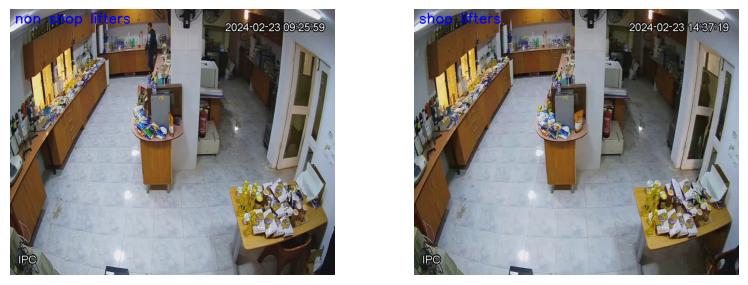

In [11]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir(DATASET_DIR)

random_range = random.sample(range(len(all_classes_names)), 2)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{DATASET_DIR}/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{DATASET_DIR}/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [12]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list



In [13]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [14]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: non shop lifters
Extracting Data of Class: shop lifters


In [17]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [19]:
# Split the Data into Train ( 85% ) and Test Set ( 15% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                         test_size = 0.15, shuffle = True, random_state = seed_constant)

print(f"num of features: {len(features_train)} , and shape is {features_train.shape}")
print(f"num of labels: {len(features_test)} , and shape is {features_test.shape}")
print(f"num of video files: {len(labels_train)}")

num of features: 726 , and shape is (726, 20, 64, 64, 3)
num of labels: 129 , and shape is (129, 20, 64, 64, 3)
num of video files: 726


In [30]:
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, Dropout, Flatten, Dense, TimeDistributed
#model architecture
def create_convlstm_model():

    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(1, activation= "sigmoid"))

    # Return the constructed convlstm model.
    return model

In [31]:
convlstm_model= create_convlstm_model()
convlstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,881 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,881 (140.16 KB)

 Trainable params: 35,881 (140.16 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
convlstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# ModelCheckpoint: Save the model after every epoch.
checkpoint = ModelCheckpoint(
    'shoplifting_classification.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [34]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [35]:
# ReduceLROnPlateau: Reduce the learning rate when the metric has stopped improving.
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [36]:
history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4,
                             shuffle = True, validation_split = 0.15,
                             callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau])

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 116s 409ms/step - accuracy: 0.6005 - loss: 0.6788 - val_accuracy: 0.5688 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 46s 48ms/step - accuracy: 0.6366 - loss: 0.6628 - val_accuracy: 0.5688 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6470 - loss: 0.6375 - val_accuracy: 0.8991 - val_loss: 0.4394 - learning_rate: 0.0010
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8303 - loss: 0.4050 - val_accuracy: 0.9358 - val_loss: 0.1352 - learning_rate: 0.0010
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8801 - loss: 0.2613 - val_accuracy: 0.9266 - val_loss: 0.1210 - learning_rate: 0.0010
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9248 - loss: 0.1697 - val_accuracy: 0.9358 - val_loss: 0.0821 - learning_rate: 0.0010
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9443 - lo

In [37]:
# function to plot accuracy and loss

def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):

    plt.figure(figsize=(10,5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')

    plt.ylabel('Accuracy')
    plt.legend(loc=0)

    # Create a new figure with plt.figure()
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

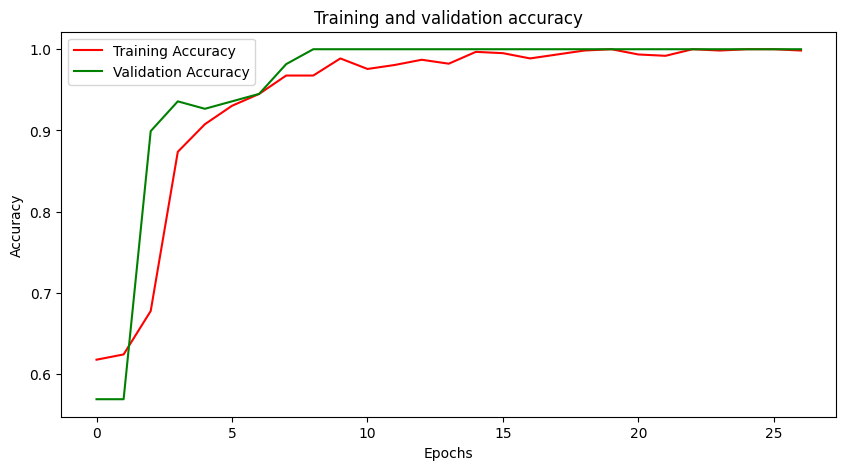

<Figure size 640x480 with 0 Axes>

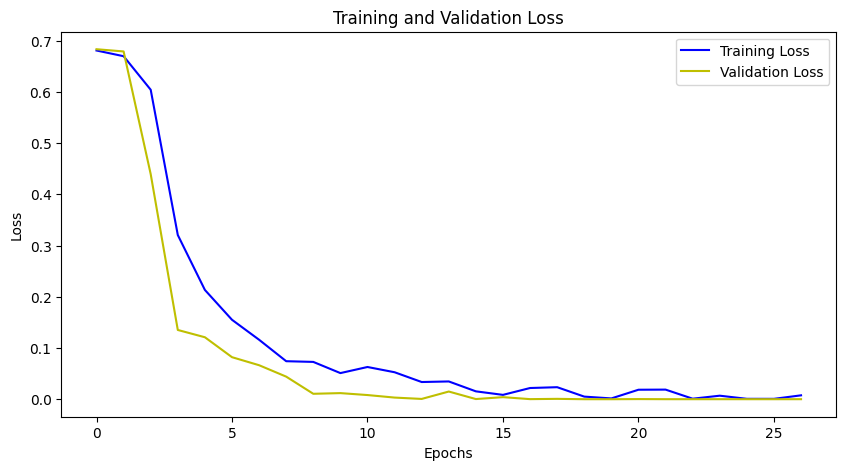

In [38]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = history.epoch

plot_acc_loss(acc, val_acc, loss, val_loss, epochs)

In [40]:
# Save the model
convlstm_model.save('shoplifting_convlstm_model.h5')
convlstm_model.save('shoplifting_convlstm_model.keras')


In [43]:
#load model
from tensorflow.keras.models import load_model
model = load_model('shoplifting_convlstm_model.h5')

In [44]:
test_loss, test_accuracy = model.evaluate(features_test, labels_test)
print('Validation loss:', test_loss)
print('Validation accuracy:', test_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - accuracy: 1.0000 - loss: 1.7126e-05
Validation loss: 1.53484088514233e-05
Validation accuracy: 1.0


In [45]:
#model architecture
def create_convlstm_model():

    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(1, activation= "sigmoid"))

    # Return the constructed convlstm model.
    return model

In [46]:
convlstm_new_model= create_convlstm_model()
convlstm_new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_8 (ConvLSTM2D)           │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_10 (ConvLSTM2D)          │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)          │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           2,881 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,881 (140.16 KB)

 Trainable params: 35,881 (140.16 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from keras.metrics import Precision, Recall

convlstm_new_model.compile( optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])


In [50]:
history = convlstm_new_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 2,
                             shuffle = True, validation_split = 0.15,
                             callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau])

Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 121s 212ms/step - accuracy: 0.6333 - loss: 0.6731 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6606 - val_loss: 0.6229 - val_precision: 0.7083 - val_recall: 0.3617 - learning_rate: 0.0010
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.7326 - loss: 0.5148 - precision: 0.6947 - recall: 0.4282 - val_accuracy: 0.9358 - val_loss: 0.1615 - val_precision: 0.8704 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.9002 - loss: 0.2422 - precision: 0.8044 - recall: 0.9462 - val_accuracy: 0.9541 - val_loss: 0.0979 - val_precision: 0.9773 - val_recall: 0.9149 - learning_rate: 0.0010
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9367 - loss: 0.1461 - precision: 0.8971 - recall: 0.9238 - val_accuracy: 0.9541 - val_loss: 0.0775 - val_precision: 0.9773 - val_recall: 0.9149 - learning_rate: 0.0010
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 20s 38

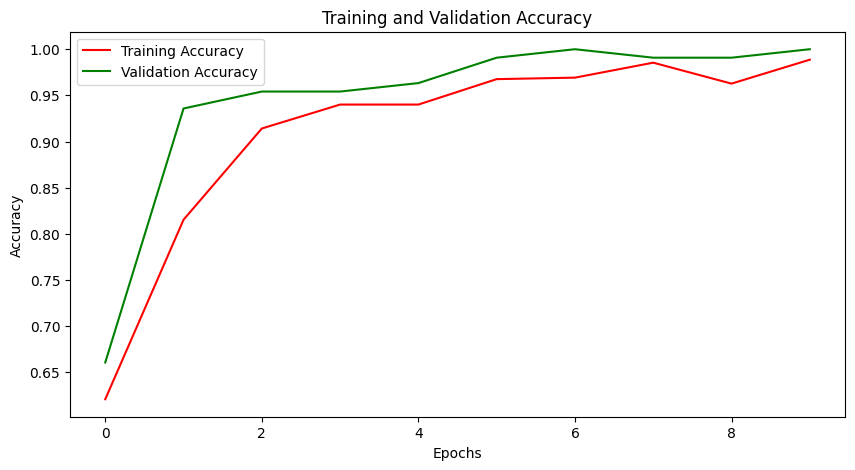

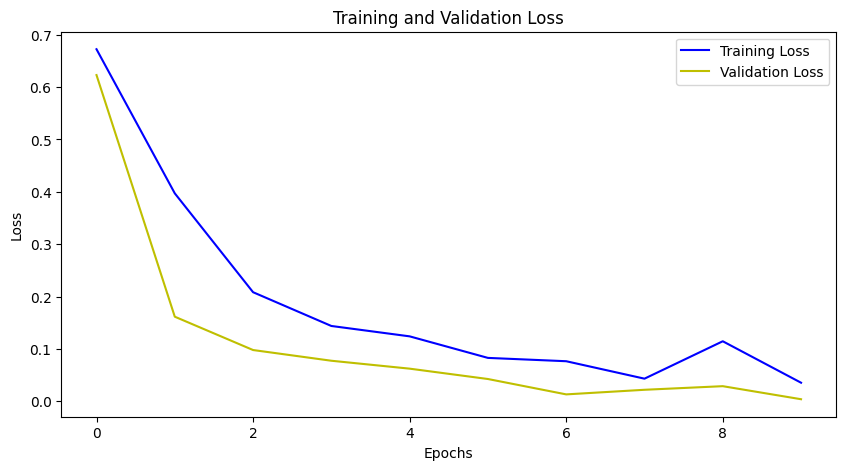

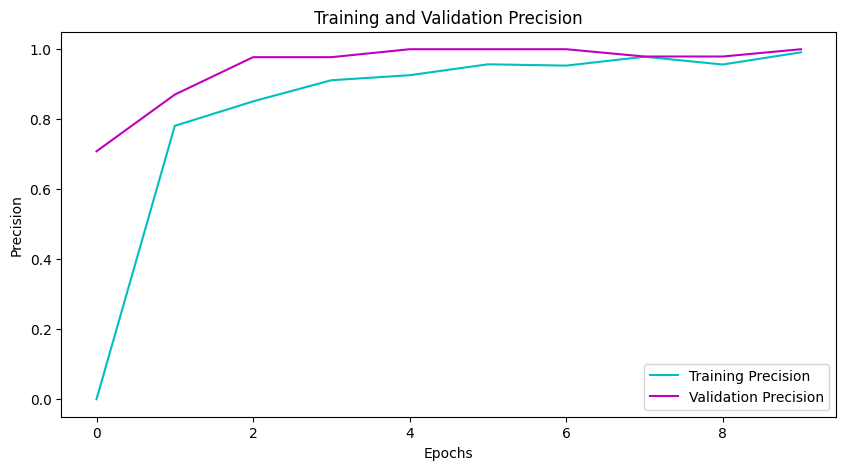

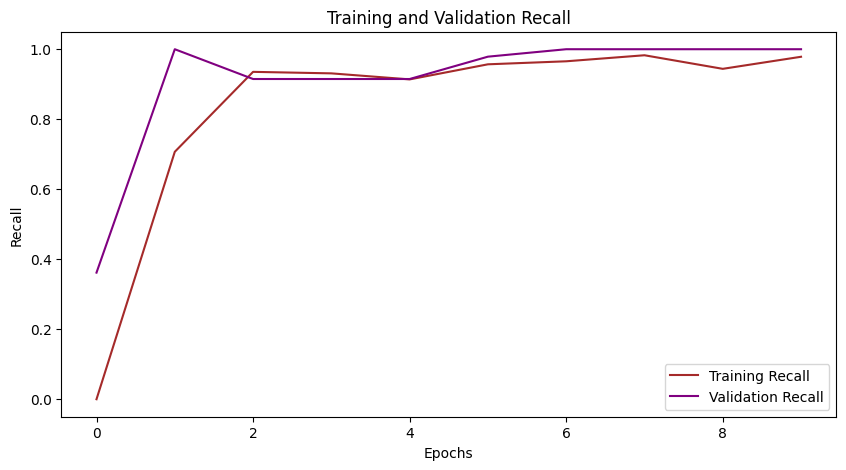

In [51]:
import matplotlib.pyplot as plt

# Function to plot accuracy, loss, precision, and recall
def plot_metrics(acc, val_acc, loss, val_loss, precision, val_precision, recall, val_recall, epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, precision, 'c', label='Training Precision')
    plt.plot(epochs, val_precision, 'm', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, recall, 'brown', label='Training Recall')
    plt.plot(epochs, val_recall, 'purple', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend(loc=0)
    plt.show()


# Extracting history values
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']
precision = model_history['precision']
val_precision = model_history['val_precision']
recall = model_history['recall']
val_recall = model_history['val_recall']

epochs = history.epoch

# Call the updated function
plot_metrics(acc, val_acc, loss, val_loss, precision, val_precision, recall, val_recall, epochs)


In [52]:
convlstm_new_model.save('shoplifting_convlstm_model_new.h5')
convlstm_new_model.save('shoplifting_convlstm_model_new.keras')

In [ ]:
#load model
model = load_model('shoplifting_convlstm_model_new.h5')

In [55]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(features_test, labels_test)

print('Validation Loss:', test_loss)
print('Validation Accuracy:', test_accuracy)
print('Validation Precision:', test_precision)
print('Validation Recall:', test_recall)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 5.7556e-04 - precision: 1.0000 - recall: 1.0000
Validation Loss: 0.0004947367124259472
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 783ms/step


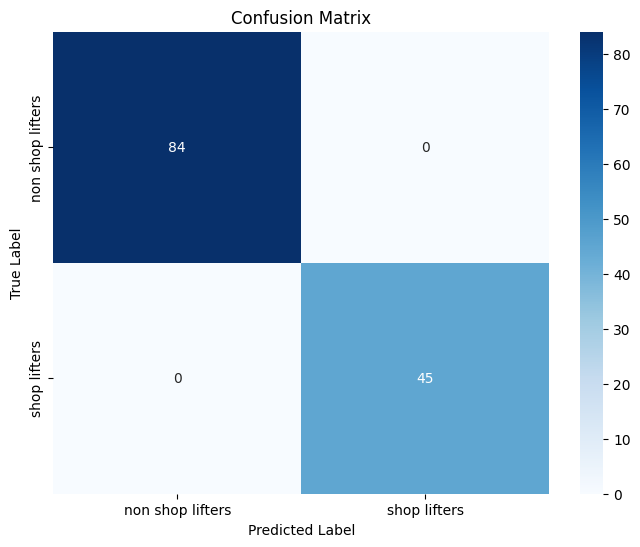

                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00        84
    shop lifters       1.00      1.00      1.00        45

        accuracy                           1.00       129
       macro avg       1.00      1.00      1.00       129
    weighted avg       1.00      1.00      1.00       129



In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
model = load_model('shoplifting_convlstm_model_new.h5')

# Get true labels and predictions
y_pred_probs = model.predict(features_test)  # Get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold at 0.5 for binary classification
y_true = labels_test  # True labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ["non shop lifters", "shop lifters"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))
